In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

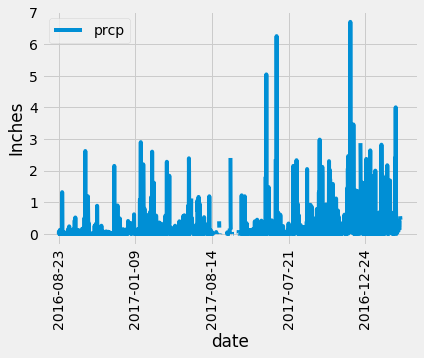

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_data_point=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores

last_12_months=dt.date(2017 , 8 , 23)-dt.timedelta(days=365)
results=session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date>=last_12_months).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results,columns=['date','prcp']).set_index('date')

# Sort the dataframe by date
df.sort_values(['date'])
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(rot=90)
plt.ylabel('Inches')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Measurement.station)).all()

[(19550)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).\
all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active=session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()
sel=[Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
result= session.query(*sel).\
filter(Measurement.station==most_active[0]).all()
print(result)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


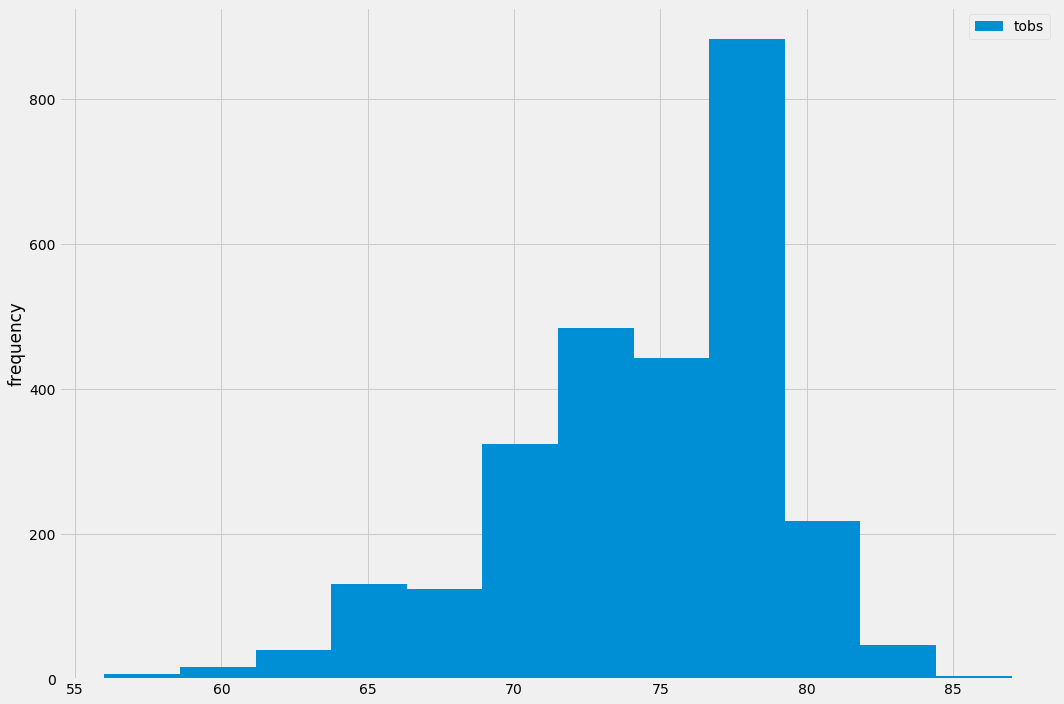

<Figure size 432x288 with 0 Axes>

In [46]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_tob_station=session.query(Measurement.station,func.count(Measurement.tobs)).\
filter(Measurement.date>=last_12_months).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()
temp_data= session.query(Measurement.tobs).\
filter(Measurement.station==high_tob_station[0]).all()
temp_df = pd.DataFrame(temp_data, columns=["tobs"])
# create the plot
plt.figure(figsize=(15,10))
plt.hist(temp_df["tobs"], bins=12)
plt.ylabel("frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Save the plot
# plt.tight_layout()
plt.savefig("temp.png")
plt.show()

## Bonus Challenge Assignment

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [48]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps = calc_temps('2017-02-28', '2017-03-05')
temps

[(64.0, 72.02777777777777, 78.0)]

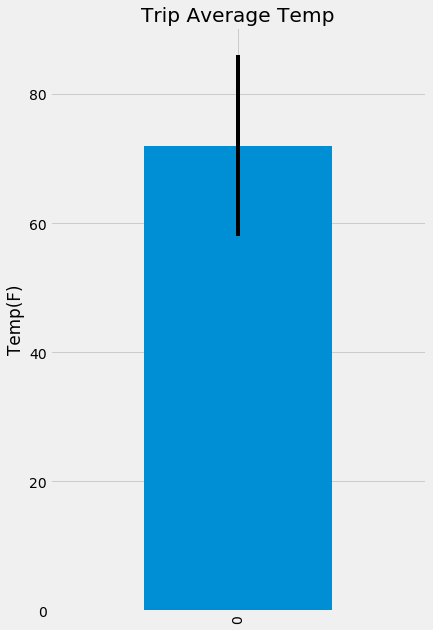

<Figure size 432x288 with 0 Axes>

In [73]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(temps, columns=["t_min", "t_avg", "t_max"])
plt.figure(figsize=(6,10))
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]))
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
plt.show()
# Save the plot
plt.tight_layout()
plt.savefig("avg_temp.png")
plt.show()

In [50]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-02-28'
end_date = '2017-03-05'
sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*sel).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(func.count(Measurement.prcp).desc()).all()
for a in rainfall:
    print(a)

(6, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(6, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(6, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(6, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(5, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(3, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(2, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)


In [53]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("03-01")

[(64.0, 70.0327868852459, 76.0)]

In [71]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
start_date='2016-03-10'
end_date='2016-03-20'
from sqlalchemy import and_
date_list=session.query(func.strftime("%m-%d",Measurement.date)).filter(and_( Measurement.date >=start_date), (Measurement.date <=end_date)).all()
date_list
# for d in date_list:
#     normal=daily_normals(d)
#     normals.append(normal)

[('03-10'),
 ('03-11'),
 ('03-12'),
 ('03-13'),
 ('03-14'),
 ('03-15'),
 ('03-16'),
 ('03-17'),
 ('03-18'),
 ('03-19'),
 ('03-20'),
 ('03-10'),
 ('03-11'),
 ('03-12'),
 ('03-13'),
 ('03-14'),
 ('03-15'),
 ('03-16'),
 ('03-17'),
 ('03-18'),
 ('03-19'),
 ('03-20'),
 ('03-10'),
 ('03-11'),
 ('03-12'),
 ('03-14'),
 ('03-15'),
 ('03-16'),
 ('03-17'),
 ('03-18'),
 ('03-19'),
 ('03-20'),
 ('03-10'),
 ('03-11'),
 ('03-14'),
 ('03-15'),
 ('03-16'),
 ('03-10'),
 ('03-11'),
 ('03-12'),
 ('03-14'),
 ('03-16'),
 ('03-17'),
 ('03-18'),
 ('03-10'),
 ('03-11'),
 ('03-12'),
 ('03-13'),
 ('03-14'),
 ('03-15'),
 ('03-16'),
 ('03-17'),
 ('03-18'),
 ('03-19'),
 ('03-20'),
 ('03-10'),
 ('03-11'),
 ('03-12'),
 ('03-13'),
 ('03-14'),
 ('03-15'),
 ('03-16'),
 ('03-17'),
 ('03-18'),
 ('03-19'),
 ('03-20')]

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
